<a href="https://colab.research.google.com/github/simsekergun/TopologyOptimization/blob/main/Classification_with_Light_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ceviche

  Preparing metadata (setup.py) ... done
  Created wheel for pyMKL: filename=pyMKL-0.0.3-py3-none-any.whl size=6742 sha256=dfbdf06af984aacfb958ad1d270c2cee1623909f76af589407fc828212b8c92f
  Stored in directory: /root/.cache/pip/wheels/18/f2/60/3ed6da007176ae6dbcabb01d0d20ea948424a3f1c0efb8de8a
Successfully built pyMKL


In [2]:
## if scikit-image is not installed, uncomment the following line
# pip install scikit-image

In [3]:
import pandas as pd
import numpy as np
import autograd.numpy as npa
from scipy import interpolate
import copy
from matplotlib.pyplot import figure
from random import randrange
from scipy.interpolate import RegularGridInterpolator

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import disk

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

import pandas as pd
from google.colab import files

In [4]:
# check the dataset
df = pd.read_csv('https://raw.githubusercontent.com/simsekergun/TopologyOptimization/refs/heads/main/training0s.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
tr0 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/TopologyOptimization/refs/heads/main/training0s.csv', header=None).to_numpy()
tr1 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/TopologyOptimization/refs/heads/main/training1s.csv', header=None).to_numpy()
tr2 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/TopologyOptimization/refs/heads/main/training2s.csv', header=None).to_numpy()

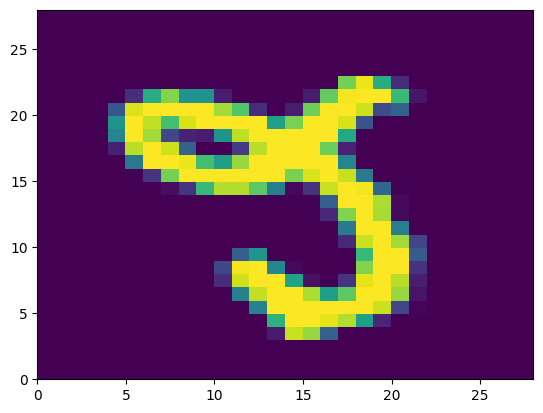

In [7]:
training0s = np.reshape(tr0,(20,28,28))
training1s = np.reshape(tr1,(20,28,28))
training2s = np.reshape(tr2,(20,28,28))

plt.pcolor(training2s[0,:,:])

In [8]:
# The angular frequency
omega1=2*np.pi*5e14
# Spatial resolution in meters
dl=10e-9
# Number of pixels in x-direction
Nx=600
# Number of pixels in y-direction
Ny=600
# Number of pixels in the PMLs in each direction
Npml=40
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=4.0
# Radius of the smoothening features
blur_radius=2
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=20.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Space between the PMLs and the design region (in pixels)
space=80
# Width of the waveguide (in pixels)
wg_width=50
# Length in pixels of the source/probe slices on each side of the center point
space_slice=16
# extra space
extra=50

# Number of epochs in the optimization for each target
Nsteps= 10
# Step size for the Adam optimizer
step_size=5e-3
######

Npixel = 70
Npixel_half = Npixel//2
Nx_half = 300
Ny_half = 400

In [9]:
def get_target(mnist_data,iindex,Npixel,epsr_max,epsr_min):
  xA = np.arange(0,28)
  yA = np.arange(0,28)

  xi = np.linspace(0,28,Npixel)
  yi = np.linspace(0,28,Npixel)
  xg, yg = np.meshgrid(xi, yi, indexing='ij')
  z = mnist_data[iindex,:,:]/255
  interp = RegularGridInterpolator((xA, yA), z,bounds_error=False, fill_value=None)
  zi = interp((xg, yg))
  epsr_scaled = epsr_min+(zi - np.min(zi)) / (np.max(zi) - np.min(zi)) * (epsr_max-epsr_min)
  return epsr_scaled

In [10]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)),
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))

    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius,Nshape):
    """Helper function used below for creating the conv kernel"""
    rr, cc = rr, cc = disk((radius, radius), radius+1, shape=(Nshape, Nshape))
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

# Then we define the function to apply the operation
def operator_blur(rho, radius=2, N=1, Nshape=50):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter

    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """
    kernel = _create_blur_kernel(radius, Nshape)

    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]

    return rho

def viz_sim(epsrnotarget, epsr0, epsr1, epsr2, sourcenotarget,source0, source1, source2, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'"""
    simulation0 = fdfd_ez(omega1, dl, epsrnotarget, [Npml, Npml])
    _, _, Ez0 = simulation0.solve(sourcenotarget)
    simulation1 = fdfd_ez(omega1, dl, epsr0, [Npml, Npml])
    _, _, Ez1 = simulation1.solve(source0)
    simulation2 = fdfd_ez(omega1, dl, epsr1, [Npml, Npml])
    _, _, Ez2 = simulation2.solve(source1)
    simulation3 = fdfd_ez(omega1, dl, epsr2, [Npml, Npml])
    _, _, Ez3 = simulation3.solve(source2)

    fig, ax = plt.subplots(2, 4, constrained_layout=True, figsize=(20,12))
    ceviche.viz.abs(Ez1, outline=epsr0, ax=ax[0,0], cbar=False)
    ceviche.viz.abs(Ez2, outline=epsr1, ax=ax[0,1], cbar=False)
    ceviche.viz.abs(Ez3, outline=epsr2, ax=ax[0,2], cbar=False)
    ceviche.viz.abs(Ez0, outline=epsrnotarget, ax=ax[0,3], cbar=False)
    ceviche.viz.abs(epsr0, ax=ax[1,0], cmap='Greys', cbar=True)
    ceviche.viz.abs(epsr1, ax=ax[1,1], cmap='Greys', cbar=True)
    ceviche.viz.abs(epsr2, ax=ax[1,2], cmap='Greys', cbar=True)
    ceviche.viz.abs(epsrnotarget, ax=ax[1,3], cmap='Greys', cbar=True)
    for sl in slices:
        ax[0,0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[0,1].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[0,2].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[0,3].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
    ax[0,0].set_title('Ez for epsr0')
    ax[0,1].set_title('Ez for epsr1')
    ax[0,2].set_title('Ez for epsr2')
    ax[0,3].set_title('Ez for no target')
    ax[1,0].set_title('epsr0')
    ax[1,1].set_title('epsr1')
    ax[1,2].set_title('epsr2')
    ax[1,3].set_title('epsr no target')

    return (simulation0, simulation1, simulation2, simulation3, ax, fig)

def do_sim(epsrnotarget, epsr0, epsr1, epsr2, sourcenotarget,source0, source1, source2, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'"""
    #simulation0 = fdfd_ez(omega1, dl, epsrnotarget, [Npml, Npml])
    #_, _, Ez0 = simulation0.solve(sourcenotarget)
    simulation1 = fdfd_ez(omega1, dl, epsr0, [Npml, Npml])
    _, _, Ez1 = simulation1.solve(source0)
    simulation2 = fdfd_ez(omega1, dl, epsr1, [Npml, Npml])
    _, _, Ez2 = simulation2.solve(source1)
    simulation3 = fdfd_ez(omega1, dl, epsr2, [Npml, Npml])
    _, _, Ez3 = simulation3.solve(source2)
    return (simulation1, simulation2, simulation3)

def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(float)


def epsr_parameterization(rho, bg_rho, design_region, radius=2, N_blur=1, beta=100, eta=0.5, N_proj=1, space=80, wg_width=50):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)

    rho = operator_blur(rho, radius=radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)

    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)

    rho = epsr_min + (epsr_max-epsr_min) * rho
    rho = npa.where(rho < epsr_min, epsr_min, rho)
    return rho

In [11]:
def init_domain(Nx, Ny, Npml, space=80, wg_width=50, space_slice=16, wg_shift=9):
    """Initializes the domain and design region"""
    rho=np.zeros((Nx, Ny))
    bg_rho = np.zeros((Nx, Ny))

    design_region = np.zeros((Nx, Ny))

    # Input waveguide
    bg_rho[0:Npml+space+extra-Npixel, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1.96/(epsr_max-epsr_min)

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+extra//2+1),
                        y=np.arange(Ny//2-wg_width//2, Ny//2+wg_width//2))

    # Output waveguide 1
    bg_rho[int(Nx-Npml-space-extra)::, Npml+space+wg_shift+extra:Npml+space+wg_width+wg_shift+extra] = 1.96/(epsr_max-epsr_min)

    # Output waveguide 2
    bg_rho[int(Nx-Npml-space-extra)::, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1.96/(epsr_max-epsr_min)

    # Output waveguide 3
    bg_rho[int(Nx-Npml-space-extra)::, Ny-extra-Npml-space-wg_width-wg_shift:Ny-extra-Npml-space-wg_shift] = 1.96/(epsr_max-epsr_min)


    o1center = Npml+space+wg_shift+extra+wg_width//2
    o2center = Ny//2
    o3center = Ny-extra-Npml-space-wg_width-wg_shift+wg_width//2
    port_half_length = wg_width//2+5

    # Output probe slice 1
    output_slice1 = Slice(x=np.array(Nx-Npml-1),
        y=np.arange(o1center-port_half_length, o1center+port_half_length))

    # Output probe slice 2
    output_slice2 = Slice(x=np.array(Nx-Npml-1),
        y=np.arange(o2center-port_half_length, o2center+port_half_length))

    # Output probe slice 3
    output_slice3 = Slice(x=np.array(Nx-Npml-1),
        y=np.arange(o3center-port_half_length, o3center+port_half_length))

    design_region[Npml+space+extra:Npml+space+extra+Nx_half, (Ny-Ny_half)//2:(Ny-Ny_half)//2+Ny_half] = 1

    # Const init
    rho = design_region * 0.5

    return rho, bg_rho, design_region, input_slice, output_slice1, output_slice2, output_slice3


In [12]:
def get_target_permittivities(itest,rho0):
  #_, bg_rho, design_region, target_region, input_slice, output_slice1, output_slice2, output_slice3 = init_domain(Nx, Ny, Npml, space=80, wg_width=50, space_slice=16, wg_shift=9)
  epsr0_scaled = get_target(training0s,itest,Npixel,epsr_max,epsr_min)
  epsr1_scaled = get_target(training1s,itest,Npixel,epsr_max,epsr_min)
  epsr2_scaled = get_target(training2s,itest,Npixel,epsr_max,epsr_min)

  epsr0=np.zeros((Nx, Ny))
  epsr0[extra+Npml+space-Npixel:Npml+space+extra, Ny//2-Npixel_half:Ny//2+Npixel_half] = epsr0_scaled-epsr_min

  epsr1=np.zeros((Nx, Ny))
  epsr1[extra+Npml+space-Npixel:Npml+space+extra, Ny//2-Npixel_half:Ny//2+Npixel_half] = epsr1_scaled-epsr_min

  epsr2=np.zeros((Nx, Ny))
  epsr2[extra+Npml+space-Npixel:Npml+space+extra, Ny//2-Npixel_half:Ny//2+Npixel_half] = epsr2_scaled-epsr_min

  epsr_with0 = rho0+epsr0
  epsr_with1 = rho0+epsr1
  epsr_with2 = rho0+epsr2
  return epsr_with0, epsr_with1, epsr_with2


In [14]:
def get_epsr(itest, rho,  bg_rho, design_region):
  rho0 = mask_combine_rho(rho, bg_rho, design_region)
  rho0 = epsr_min + (epsr_max-epsr_min) * rho0
  rho0 = npa.where(rho0 < epsr_min, epsr_min, rho0)
  epsr_without = rho0
  epsr_with0, epsr_with1, epsr_with2 = get_target_permittivities(itest,rho0)
  return epsr_without, epsr_with0, epsr_with1, epsr_with2

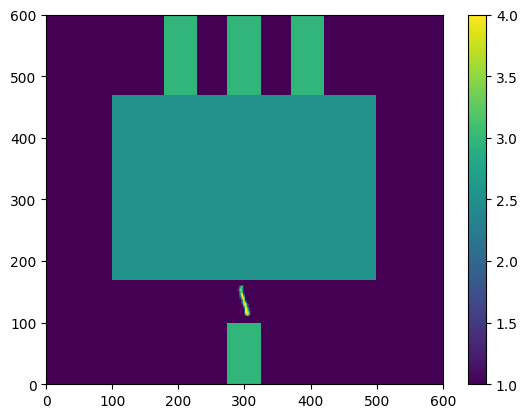

In [15]:
rho, bg_rho, design_region, input_slice, output_slice1, output_slice2, output_slice3 = init_domain(Nx, Ny, Npml, space=80, wg_width=50, space_slice=16, wg_shift=9)
epsr_without, epsr_with0, epsr_with1, epsr_with2 = get_epsr(0, rho,  bg_rho, design_region)

plt.pcolor(epsr_with1)
plt.colorbar()
plt.show()

In [17]:
def set_source_n_probes(epsr_without, epsr_with0, epsr_with1, epsr_with2):
  # Setup sources
  sourcenotarget = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_without, m=1)
  source0 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_with0, m=1)
  source1 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_with1, m=1)
  source2 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_with2, m=1)

  # Setup probes
  probe1 = insert_mode(omega1, dl, output_slice1.x, output_slice1.y, epsr_with0, m=1)
  probe2 = insert_mode(omega1, dl, output_slice2.x, output_slice2.y, epsr_with1, m=1)
  probe3 = insert_mode(omega1, dl, output_slice3.x, output_slice3.y, epsr_with2, m=1)

  # Setup notarget probes
  probe1notarget = insert_mode(omega1, dl, output_slice1.x, output_slice1.y, epsr_without, m=1)
  probe2notarget = insert_mode(omega1, dl, output_slice2.x, output_slice2.y, epsr_without, m=1)
  probe3notarget = insert_mode(omega1, dl, output_slice3.x, output_slice3.y, epsr_without, m=1)
  return sourcenotarget, source0, source1, source2, probe1, probe2, probe3, probe1notarget, probe2notarget, probe3notarget

In [18]:
# Define optimization objective
def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))*1e6

def callback_output_structure(iteration, of_list, rho):
    """Callback function to output fields and the structures (for making sweet gifs)"""
    starting_index=0
    rho = rho.reshape((Nx, Ny))

    epsr_without, epsr_with0, epsr_with1, epsr_with2 = get_epsr(itest, rho,  bg_rho, design_region)
    sourcenotarget, source0, source1, source2, probe1, probe2, probe3, probe1notarget, probe2notarget, probe3notarget = set_source_n_probes(epsr_without, epsr_with0, epsr_with1, epsr_with2)

    # Initialize the domain
    simulation1, simulation2, simulation3 = do_sim(epsr_without,epsr_with0, epsr_with1, epsr_with2, sourcenotarget, source0, source1, source2, slices=[input_slice, output_slice1, output_slice2, output_slice3])

def callback_beta_schedule(iteration, of_list, rho):
    """Callback function for the optimizer to schedule changes to beta with the iteration number"""
    global beta

    if iteration < 40:
        beta = 30
    elif 40 <= iteration < 61:
        beta = 50
    elif 61 <= iteration < 90:
        beta = 75
    else:
        beta = 100


    # Chain with the output structure callback
    callback_output_structure(iteration, of_list, rho)


In [24]:
def objective(rho):
    """Objective function called by optimizer

    1) Takes the density distribution as input
    2) Constructs epsr
    3) Runs the simulations
    4) Returns the product of overlap integrals between the output waveguide fields
       and the desired mode fields for all three digits
    """

    rho = rho.reshape((Nx, Ny))
    epsr_without, epsr_with0, epsr_with1, epsr_with2 = get_epsr(itest, rho,  bg_rho, design_region)

    simulation1.eps_r = epsr_with0
    simulation2.eps_r = epsr_with1
    simulation3.eps_r = epsr_with2

    _, _, Ez1 = simulation1.solve(source0)
    _, _, Ez2 = simulation2.solve(source1)
    _, _, Ez3 = simulation3.solve(source2)

    # Calculate overlap integrals for all three digits
    overlap1 = mode_overlap(Ez1, probe1)
    overlap1others = overlap1 + mode_overlap(Ez1, probe2)+mode_overlap(Ez1, probe3)
    overlap2 = mode_overlap(Ez2, probe2)
    overlap2others = overlap2 + mode_overlap(Ez2, probe1)+mode_overlap(Ez2, probe3)
    overlap3 = mode_overlap(Ez3, probe3)
    overlap3others = overlap3 + mode_overlap(Ez3, probe1)+mode_overlap(Ez3, probe2)


    overlap = (overlap1 / overlap1others) + (overlap2 / overlap2others) + (overlap3 / overlap3others)**2.0

    return overlap


In [25]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [26]:
rho, bg_rho, design_region, input_slice, output_slice1, output_slice2, output_slice3 = init_domain(Nx, Ny, Npml, space=80, wg_width=50, space_slice=16, wg_shift=9)

for itest in range(20):
  epsr_without, epsr_with0, epsr_with1, epsr_with2 = get_epsr(itest, rho,  bg_rho, design_region)

  sourcenotarget, source0, source1, source2, probe1, probe2, probe3, probe1notarget, probe2notarget, probe3notarget = set_source_n_probes(epsr_without, epsr_with0, epsr_with1, epsr_with2)

  simulation1 = fdfd_ez(omega1, dl, epsr_with0, [Npml, Npml])
  _, _, Ez1 = simulation1.solve(source0)
  simulation2 = fdfd_ez(omega1, dl, epsr_with1, [Npml, Npml])
  _, _, Ez2 = simulation2.solve(source1)
  simulation3 = fdfd_ez(omega1, dl, epsr_with2, [Npml, Npml])
  _, _, Ez3 = simulation3.solve(source2)

  # Update the overlap integrals for the three digits
  E01 = mode_overlap(Ez1, probe1)
  E02 = mode_overlap(Ez2, probe2)
  E03 = mode_overlap(Ez3, probe3)

  # Compute the gradient of the objective function using reverse-mode differentiation
  objective_jac = jacobian(objective, mode='reverse')
  # Maximize the objective function using an ADAM optimizer
  (rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                          Nsteps=10, direction='max', step_size=step_size, callback=callback_beta_schedule)

  rho = rho_optimum.reshape(Nx,Ny)

  check_m = np.where(rho>0.1)
  print('rho min and max:', np.min(rho[check_m]), ' and ', np.max(rho[check_m]))

Epoch:   1/ 10 | Duration: 50.28 secs | Value: 9.115952e-01
Epoch:   2/ 10 | Duration: 51.28 secs | Value: 9.872962e-01
Epoch:   3/ 10 | Duration: 50.46 secs | Value: 1.066191e+00
Epoch:   4/ 10 | Duration: 49.63 secs | Value: 1.150040e+00
Epoch:   5/ 10 | Duration: 49.62 secs | Value: 1.241422e+00
Epoch:   6/ 10 | Duration: 50.60 secs | Value: 1.344009e+00
Epoch:   7/ 10 | Duration: 50.45 secs | Value: 1.456677e+00
Epoch:   8/ 10 | Duration: 50.38 secs | Value: 1.533091e+00
Epoch:   9/ 10 | Duration: 50.30 secs | Value: 1.579298e+00
Epoch:  10/ 10 | Duration: 49.34 secs | Value: 1.617224e+00
rho min and max: 0.4492074356917909  and  0.5507754552797082
Epoch:   1/ 10 | Duration: 49.95 secs | Value: 1.716217e+00
Epoch:   2/ 10 | Duration: 49.99 secs | Value: 1.926308e+00
Epoch:   3/ 10 | Duration: 49.48 secs | Value: 2.040599e+00
Epoch:   4/ 10 | Duration: 49.29 secs | Value: 2.230766e+00
Epoch:   5/ 10 | Duration: 49.87 secs | Value: 2.440289e+00
Epoch:   6/ 10 | Duration: 49.77 secs |

In [33]:
rho = rho_optimum.reshape(Nx,Ny)
df = pd.DataFrame(rho)
df.to_csv('final_rho.csv')
files.download('final_rho.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>